In [1]:
import pandas as pd
import numpy as np
import matplotlib

In [2]:
df = pd.read_csv('/content/Bengaluru_House_Data.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df2 = df.drop(['area_type','availability','society','balcony'],axis='columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [4]:
df3 = df2.dropna()
df3.head()
df3['size'].unique()
df3['BHK'] = df3['size'].apply(lambda x:int(x.split(' ')[0]))


<ipython-input-4-cbac40ee99d5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['BHK'] = df3['size'].apply(lambda x:int(x.split(' ')[0]))


In [5]:
def is_float(x):
  try:
    float(x)
  except:
    return False
  return True

In [6]:
df3[~df3['total_sqft'].apply(is_float)].head()

,location,size,total_sqft,bath,price,BHK
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2


In [7]:
def convert_sqft_to_number(x):
  tokens = x.split('-')
  if len(tokens)==2:
    return(float(tokens[0])+float(tokens[1]))/2
  try:
    return float(x)
  except:
    return None

In [8]:
df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_number)
df4.loc[648]

location        Arekere
size          9 Bedroom
total_sqft          NaN
bath                9.0
price             265.0
BHK                   9
Name: 648, dtype: object

In [9]:
df4 = df4.dropna()
df4.isna().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
BHK           0
dtype: int64

In [10]:
df5 = df4.copy()
df5['price_per_sft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,BHK,price_per_sft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [11]:
df5.location.unique()

array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
       '12th cross srinivas nagar banshankari 3rd stage',
       'Havanur extension', 'Abshot Layout'], dtype=object)

In [12]:
df5.location = df5.location.apply(lambda x:x.strip())
location_stats = df5.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield               533
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           264
Thanisandra              235
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Kannur                     1
whitefiled                 1
Name: location, Length: 1287, dtype: int64

In [13]:
len(location_stats[location_stats<=10])

1047

In [14]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
Sadashiva Nagar          10
Naganathapura            10
Basapura                 10
Nagadevanahalli          10
Kalkere                  10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Kannur                    1
whitefiled                1
Name: location, Length: 1047, dtype: int64

In [15]:
df5.location = df5.location.apply(lambda x:'other'if x in location_stats_less_than_10 else x)
len(df5.location.unique())

241

In [16]:
df6 = df5[~(df5.total_sqft/df5.BHK<300)]

In [17]:
def remove_pps_outliers(df):
  df_out = pd.DataFrame()
  for key,subdf in df.groupby('location'):
    m = np.mean(subdf.price_per_sft)
    st= np.std(subdf.price_per_sft)
    reduced_df = subdf[(subdf.price_per_sft>(m-st))&(subdf.price_per_sft<(m+st))]
    df_out = pd.concat([df_out,reduced_df],ignore_index=True)
  return df_out

df7 = remove_pps_outliers(df6)
df7.shape

(10242, 7)

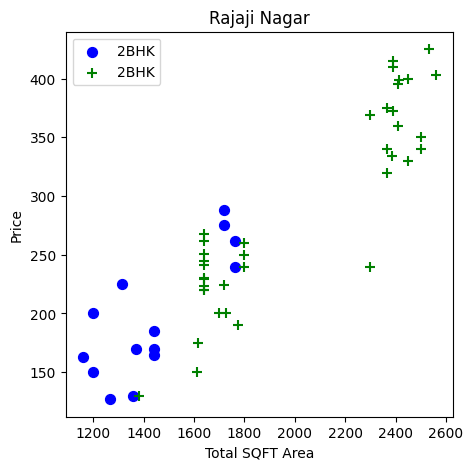

In [18]:
import matplotlib.pyplot as plt
def plot_scatter_chart(df,location):
  bhk2 = df[(df.location==location)&(df.BHK==2)]
  bhk3 = df[(df.location==location)&(df.BHK==3)]
  matplotlib.rcParams['figure.figsize'] = (5,5)
  plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2BHK',s=50)
  plt.scatter(bhk3.total_sqft,bhk3.price,marker='+',color='green',label='2BHK',s=50)
  plt.xlabel('Total SQFT Area')
  plt.ylabel('Price')
  plt.title(location)
  plt.legend()
plot_scatter_chart(df7,'Rajaji Nagar')



In [19]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('BHK'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sft),
                'std': np.std(bhk_df.price_per_sft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('BHK'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(7317, 7)

Text(0, 0.5, 'Count')

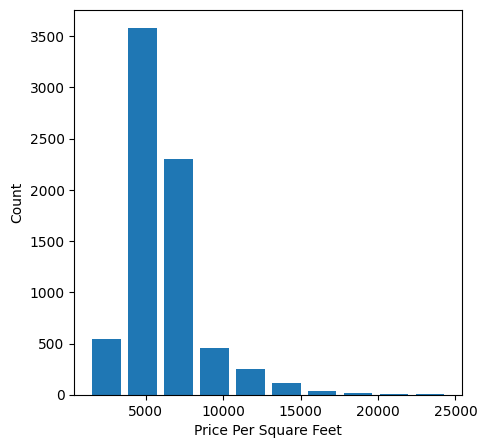

In [20]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (5,5)
plt.hist(df8.price_per_sft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

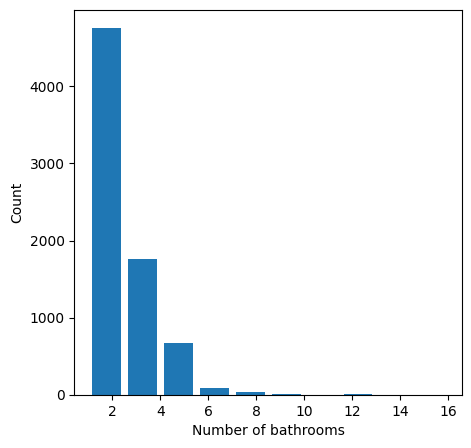

In [21]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [22]:
df8[df8.bath>df8.BHK+2]

,location,size,total_sqft,bath,price,BHK,price_per_sft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8408,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [23]:
df9 = df8[df8.bath<df8.BHK+2]

In [ ]:
df10 = df9.drop(['size','price_per_sft'],axis='columns')
df10.head(3)

one hot encoding(convert text to numeric)

In [25]:
dummies = pd.get_dummies(df10.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head(3)

,location,total_sqft,bath,price,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df12 = df11.drop('location',axis='columns')
df12.head(3)

In [32]:
X = df12.drop('price',axis='columns')
X.head(2)

,total_sqft,bath,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
y = df12.price
y.head(3)

0    428.0
1    194.0
2    235.0
Name: price, dtype: float64

In [35]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=10)


In [36]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.8629132245229443

In [38]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
cv = ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
cross_val_score(LinearRegression(),X,y,cv=cv)

array([0.82702546, 0.86027005, 0.85322178, 0.8436466 , 0.85481502])

In [39]:
def predict_price(location,sqft,bath,bhk):
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr.predict([x])[0]


In [41]:
predict_price('1st Phase JP Nagar',1000,2,3)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


82.3636761431009

In [42]:
predict_price('Indira Nagar',1000,2,3)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


191.80995089177873

IMPORTING MODEL TO PICKLE FLASK

In [43]:
import pickle
with open('bangalore_home_prices_model.pickle','wb') as f:
  pickle.dump(lr,f)

In [44]:
import json
columns = {
    'data_columns':[col.lower()for col in X.columns]
}
with open('columns.json','w') as f:
  f.write(json.dumps(columns))